In [240]:
import numpy as np
from collections import deque
import time
import random
from tqdm import trange
import os

import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym

import math

import matplotlib.pyplot as plt

In [2]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000
MIN_REPLAY_MEMEORY_SIZE = 100
# MIN_REPLAY_MEMEORY_SIZE = 1_000
MINIBATCH_SIZE = 64
UPDATE_TARGET_EVERY = 100
MIN_REWARD = -200
MEMORY_FRACTION = 0.20

EPISODES = 20_000

epsilon = 0
# epsilon = 1
EPSILON_DECAY = 0.99995
MIN_EPSILON = 0.000
# MIN_EPSILON = 0.001

SHOW_PREVIEW = False

REPLAY_MEMORY_SIZE

50000

In [3]:
env = gym.make("Acrobot-v1", render_mode="human")
# env = gym.make("MountainCar-v0")
env.reset()

TypeError: __init__() got an unexpected keyword argument 'render_mode'

In [2]:
env = gym.make("Breakout-v0", render_mode="human")

In [39]:
env.reset()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [236]:
new_state, reward, done, info = env.step(2)
new_state.shape

(210, 160, 3)

In [233]:
pip install opencv-python

     |████████████████████████████████| 60.9 MB 5.2 MB/s eta 0:00:012
Note: you may need to restart the kernel to use updated packages.


In [235]:
import cv2

In [238]:
image = cv2.cvtColor(new_state, cv2.COLOR_BGR2GRAY)
image.shape

(210, 160)

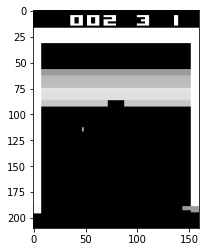

In [242]:
plt.imshow(image, cmap="gray")

In [ ]:
current_image = env.render()
type(current_image)
# dir(current_image)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, env.action_space.n)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x
    

In [ ]:
class DQNAgent:
    def __init__(self):
        
        self.model = self.create_model()
        
        self.target_model = copy.deepcopy(self.model)
        
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        
        self.target_update_counter = 0
        
        self.loss_fn = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        
    def create_model(self):
        
        return Model(len(env.observation_space.low))
    
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
    
    
    def train(self, terminal_state):
        
        if len(self.replay_memory) < MIN_REPLAY_MEMEORY_SIZE:
            return
        
        
        
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        
        #clark
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model(torch.from_numpy(current_states))
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model(torch.from_numpy(new_current_states))
        
        X = []
        y = []
        
        
        
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            
            current_qs = current_qs_list[index]
            
            if not done:
                max_future_q = torch.max(future_qs_list[index])
                new_q = reward + (DISCOUNT * max_future_q)
                
            else:
                new_q = reward
                
            
            current_qs[action] = new_q
            
            
            X.append(current_state)
            y.append(current_qs)
            
            
            
#             if index == 63:
#                 print(current_qs)
#                 print(new_q)
#                 print(current_qs[action])
#                 print(reward)
#                 print(DISCOUNT * max_future_q)
#                 print((reward + (DISCOUNT * max_future_q)))
#                 print("******************************")
        
            
        #########################################################################
        ###  model.fit   - my version for torch
        ###  self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)

        y_pred = self.model(torch.from_numpy(np.array(X)))

        

        loss = self.loss_fn(y_pred, torch.from_numpy(np.array([x.detach().numpy() for x in y])))
        
#         print(loss)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        #########################################################################
            


        
        self.target_update_counter += 1
        
            
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            
            self.target_model = copy.deepcopy(self.model)
            
            self.target_update_counter = 0
            
#             print("yes")
            

    def get_qs(self, state):
        
        return self.model(state)
    
agent = DQNAgent()

In [ ]:
for episode in trange(1, 100):
    
    episode_reward = 0
    
    
    current_state = env.reset()[0]
    
    done = False
    
    count = 0
    while not done:

        if count == 0:
            print(epsilon)        
        
        count += 1
        
        if count % 100 == 0:
            print(count)
            

    
        if np.random.random() > epsilon:
            
#             print("not random")
                
            action = torch.argmax(agent.get_qs(torch.from_numpy(current_state))).item()
            
        else:
            
#             print("random")
        
            action = np.random.randint(0, env.action_space.n)
        
#         print(agent.get_qs(torch.from_numpy(current_state)))
        
#         print(action)
            
        new_state, reward, done, _, _ = env.step(action)
        
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done)
        
        current_state = new_state
        
#         if count == 3000:
#             done = True
        
        
        # Decay epsilon
        if epsilon > MIN_EPSILON:
            epsilon *= EPSILON_DECAY
            epsilon = max(MIN_EPSILON, epsilon)    
            
#         print(epsilon)